# Adapted from the HLCA scArches mapping tutorial
This notebook is adapted from the Human Lung Cell Atlas (HLCA) reproducibility vignette:
[HLCA scArches mapping](https://github.com/LungCellAtlas/HLCA_reproducibility/blob/main/notebooks/3_atlas_extension/02_scArches_mapping.ipynb)
We reuse the structure and workflow, but all data and specific analyses are original for the human skin cell atlas (HSCA).


# Mapping HSCA Extension Datasets onto the HSCA Core with scArches

We project the query datasets onto the established HSCA core atlas using [scArches](https://www.nature.com/articles/s41587-021-01001-7) to create the HSCA extended. 
We perform this analysis using scArches version 0.6.1.


### Import modules

In [2]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import scanpy as sc
import torch
import matplotlib.pyplot as plt
import numpy as np
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import gdown
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

### File paths and directories setup:

In [ ]:
path_input_core_data = (
    "../processed_seurat_objects/atlas/HSCA_core.h5ad"
)
path_input_extension_data = (
    "../processed_seurat_objects/atlas/HSCA_only_extended_datasets_raw.h5ad"
)
dir_out_hsca_extended = "./scarches_output/HSCA/SCVI/HSCA_extended"
dir_reference_model = "./scarches_output/HSCA/SCVI/models/reference_model"  # directory where the reference model is stored
dir_surgery_models = "./scarches_output/HSCA/SCVI/models/surgery_models"  # directory where surgery model(s) will be stored
dir_surgery_embs = (
    "./scarches_output/HSCA/SCVI/models/surgery_output_embeddings"
)

## Import final HSCA core atlas used as reference for mapping query datasets

In [ ]:
reference_adata = sc.read(path_input_core_data)
reference_adata

## Import query datasets to be mapped onto the HSCA core via transfer learning

In [ ]:
target_adata = sc.read_h5ad(path_input_extension_data)
target_adata

In [ ]:
# Get a list of all unique dataset names
target_adata.obs["Dataset"].unique().tolist()

['Ahlers_Siracusa_2022',
 'Sole-boldo_Lyko_2020',
 'Kim_Nagao_2020_five_prime',
 'Zheng_Zhao_2022',
 'Singh_Sen_2022',
 'Rustagi_Singh_2022',
 'Bangert_Brunner_2024',
 'Rojahn_Brunner_2020',
 'Sun_Liu_2022',
 'Kim_Krüger_2022',
 'Mariottoni_MacLeod_2021',
 'Direder_Mildner_2022',
 'Chu_Midha_2022',
 'Wang_Atwood_2020',
 'Wiedemann_Anderson_2023',
 'Gao_Hu_2021',
 'Theocharidis_Bhasin_2022',
 'Liu_Landen_2025_1',
 'Liu_Landen_2025_2',
 'Cheng_Cho_2018_2',
 'Ganier_Lynch_2024_1',
 'Ganier_Lynch_2024_2']

In [ ]:
# Exclude dataset "Ganier_Lynch_2024_2" (only part of HSCA core, not HSCA extended)
target_adata = target_adata[target_adata.obs["Dataset"] != "Ganier_Lynch_2024_2"].copy()

In [ ]:
target_adata

AnnData object with n_obs × n_vars = 606494 × 48448
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'genes', 'barcode'
    var: 'highly_variable', 'gene_names'
    layers: 'counts', 'norm'

In [ ]:
# Check number of samples
len(target_adata.obs["sample"].unique().tolist())

112

keep gene IDs in a separate column and set gene symbols as the index

In [ ]:
reference_adata.var["gene_ids"] = reference_adata.var.index.tolist()
reference_adata.var.index = reference_adata.var.gene_names.values
reference_adata.var.drop(columns="gene_names", inplace=True)

In [ ]:
condition_key = 'sample'
cell_type_key = 'inherited_celltype_lvl_3'

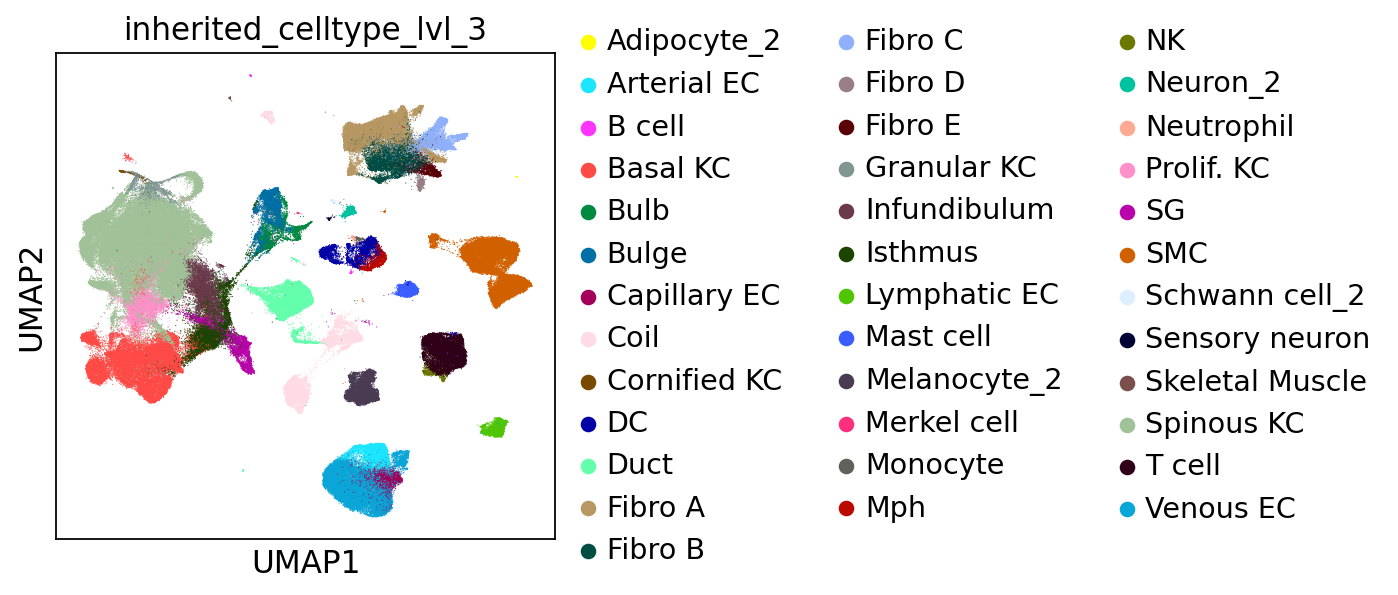

In [ ]:
sc.pl.umap(reference_adata,color='inherited_celltype_lvl_3',size=1)

Get all unique source conditions; these samples will be mapped to the HSCA core via transfer learning


In [ ]:
source_conditions = reference_adata.obs[condition_key].unique().tolist()
source_conditions

['HRS118996',
 'HRS118997',
 'HRS118998',
 'HRS118999',
 'HRS119000',
 'HRS119001',
 'HRS119002',
 'HRS119003',
 'HRS119004',
 'GSM4115878',
 'GSM4115880',
 'GSM4115885',
 'GSM4115886',
 'GSM4115868',
 'GSM4115870',
 'GSM4115872',
 'GSM4115874',
 'GSM4115875',
 'GSM4115876',
 'GSM3892577',
 'GSM3892578',
 'GSM3892579',
 'GSM3892580',
 'GSM8478430',
 'GSM8478429',
 'GSM5652699',
 'GSM5652700',
 'GSM5652701',
 'GSM5652702',
 'GSM5652703',
 'GSM5652704',
 'GSM5652705',
 'GSM5652706',
 'GSM5652707',
 'GSM5652708',
 'GSM5652709',
 'GSM5652710',
 'GSM5652711',
 'GSM5652712',
 'GSM4430462',
 'GSM4430464',
 'GSM4430466',
 'GSM4430467',
 'GSM4430468',
 'GSM4430470',
 'GSM4430471',
 'GSM4430475',
 'GSM3717037',
 'GSM3717038',
 'GSM4850587',
 'EGAF00002191947',
 'EGAF00002191954',
 'EGAF00002191956',
 'EGAF00002191945',
 'EGAF00002191949',
 'EGAF00002191953',
 'GSM5738236',
 'GSM5738237',
 'GSM5738238',
 'GSM8462811',
 'GSM8462812',
 'GSM8462813',
 'GSM8462814',
 'GSM8462815',
 'GSM8462816',
 'SA

Subset reference AnnData to the 2000 highly variable genes (matching the genes used in the query dataset)

In [ ]:
reference_adata_2000 = reference_adata[:, reference_adata.var['highly_variable'].values].copy()

In [ ]:
reference_adata_2000

AnnData object with n_obs × n_vars = 293827 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'soup_group', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.class', 'genes', 'RNA_snn_res.1.2', 'seurat_clusters', 'orig_celltype_lvl_3', 'RNA_snn_res.0.8', 'RNA_snn_res.1.6', 'fresh_or_frozen', 'RNA_snn_res.1.8', 'RNA_snn_res.1.5', 'seurat_clusters_full', 'RNA_snn_res.2', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2'
    var: 'highly_variable', 'gene_ids'
    uns: 'orig_celltype_lvl_3_colors', '

## Train reference model

We train the reference using the SCVI workflow

In [ ]:
sca.models.SCVI.setup_anndata(reference_adata_2000, batch_key=condition_key)

In [ ]:
vae = sca.models.SCVI(
    reference_adata_2000,
    n_layers=3,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [ ]:
vae.train(max_epochs=200, 
                plan_kwargs=dict(
                                 weight_decay=0.0,
                                 ),
                early_stopping= True,
                accelerator="cpu" # Use GPU, if available

                )

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 200/200: 100%|██████████| 200/200 [1:42:44<00:00, 31.26s/it, v_num=1, train_loss_step=578, train_loss_epoch=564]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [1:42:44<00:00, 30.82s/it, v_num=1, train_loss_step=578, train_loss_epoch=564]


In [ ]:
sc.AnnData(vae.get_latent_representation())

AnnData object with n_obs × n_vars = 293827 × 10

In [ ]:
reference_adata

AnnData object with n_obs × n_vars = 293827 × 35299
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'soup_group', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.class', 'genes', 'RNA_snn_res.1.2', 'seurat_clusters', 'orig_celltype_lvl_3', 'RNA_snn_res.0.8', 'RNA_snn_res.1.6', 'fresh_or_frozen', 'RNA_snn_res.1.8', 'RNA_snn_res.1.5', 'seurat_clusters_full', 'RNA_snn_res.2', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2'
    var: 'highly_variable', 'gene_ids'
    uns: 'orig_celltype_lvl_3_colors', 

Create a new AnnData object from the scVI latent representation

In [ ]:
adata_latent = sc.AnnData(vae.get_latent_representation())
adata_latent.obs['celltype'] = reference_adata_2000.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = reference_adata_2000.obs[condition_key].tolist()
adata_latent

AnnData object with n_obs × n_vars = 293827 × 10
    obs: 'celltype', 'batch'

Compute neighborhood graph, cluster cells with Leiden, and embed in UMAP.
Finally, visualize the UMAP colored by batch and cell type.

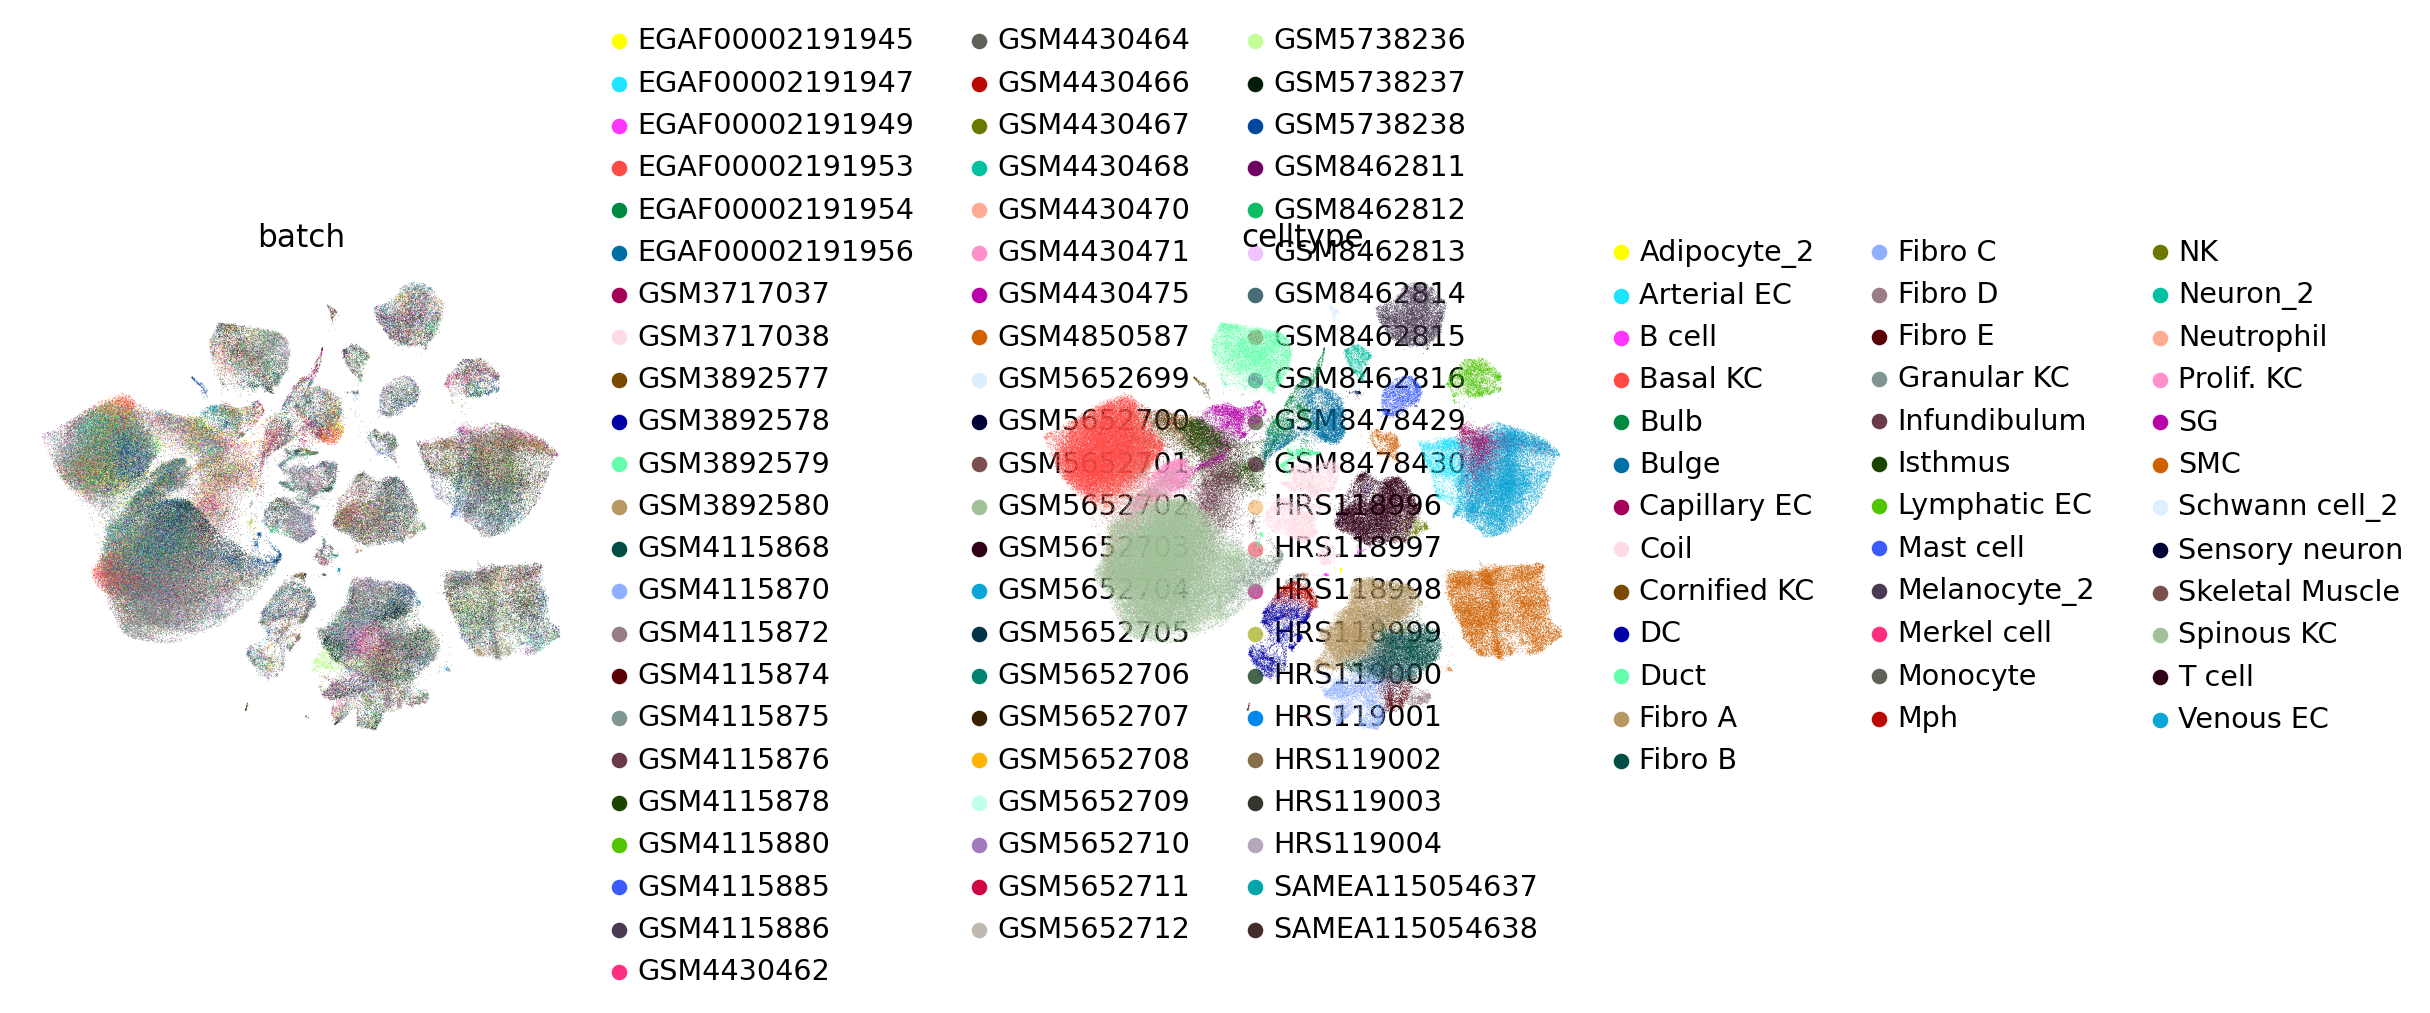

In [ ]:
sc.pp.neighbors(adata_latent)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'celltype'],
           frameon=False,
           wspace=0.6,
           )

In [ ]:
adata_latent

AnnData object with n_obs × n_vars = 293827 × 10
    obs: 'celltype', 'batch', 'leiden'
    uns: 'neighbors', 'leiden', 'umap', 'batch_colors', 'celltype_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [ ]:
adata_latent.obs.index = reference_adata_2000.obs.index

In [ ]:
reference_adata_2000.obsm['X_scvi_emb'] = adata_latent[reference_adata_2000.obs.index,:].X

In [ ]:
ref_path = dir_reference_model

save model

In [ ]:
#ref_path = dir_reference_model
#vae.save(ref_path, overwrite=True)

read model

In [ ]:
vae = sca.models.SCVI.load(dir_reference_model,reference_adata_2000)
vae

INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 3, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

## Perform surgery on reference model and train on query dataset without cell type labels

In [ ]:
target_adata

AnnData object with n_obs × n_vars = 606494 × 48448
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'genes', 'barcode'
    var: 'highly_variable', 'gene_names'
    layers: 'counts', 'norm'

In [ ]:
target_adata.obs[condition_key].unique().tolist()

['SRR15440580',
 'SRR15440581',
 'SRR15440582',
 'SRR15440583',
 'SRR15440584',
 'SRR15440585',
 'SRR15440586',
 'GSM3758115',
 'GSM3758116',
 'GSM3758117',
 'GSM3758118',
 'GSM3758119',
 'GSM3892581',
 'GSM3892582',
 'HC1zhenpi',
 'HC2zhenpi1117',
 'HC1118E',
 'HC11118D',
 'HC1119D',
 'GSM5364333',
 'GSM5364334',
 'GSM5364335',
 'GSM5364336',
 'GSM5520735',
 'GSM5520736',
 'GSM5520740',
 'GSM5534590',
 'GSM5534591',
 'GSM5534592',
 'GSM5534593',
 'GSM4653863',
 'GSM4653864',
 'GSM4653865',
 'GSM4653866',
 'GSM4653867',
 'GSM4653868',
 'GSM4653869',
 'SRR17640984',
 'SRR17640986',
 'GSM4567877',
 'GSM4567878',
 'GSM4567879',
 'GSM4567880',
 'GSM4567881',
 'GSM456788',
 'GSM5352395',
 'GSM5494683',
 'GSM3573709',
 'GSM3573711',
 'GSM4105916',
 'GSM4105918',
 'GSM4105921',
 'GSM4431901',
 'GSM4431902',
 'GSM4431903',
 'GSM4431904',
 'GSM4431905',
 'GSM6111844',
 'GSM6111845',
 'GSM6111846',
 'GSM6111847',
 'GSM6111851',
 'GSM6111848',
 'GSM6111849',
 'GSM6111850',
 'GSM6111852',
 'GSM611

In [ ]:
target_adata_2000 = target_adata[:, reference_adata_2000.var.index].copy()

In [ ]:
target_adata_2000

AnnData object with n_obs × n_vars = 606494 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'genes', 'barcode'
    var: 'highly_variable', 'gene_names'
    layers: 'counts', 'norm'

Identify genes present only in the reference or only in the target dataset (after HVG selection)

In [ ]:
diff_genes_1 = set(reference_adata_2000.var_names) - set(target_adata_2000.var_names)  # Gene, die nur in adata1 sind
diff_genes_2 = set(target_adata_2000.var_names) - set(reference_adata_2000.var_names)  # Gene, die nur in adata2 sind

print(f"Gene nur in adata1: {diff_genes_1}")
print(f"Gene nur in adata2: {diff_genes_2}")

Gene nur in adata1: set()
Gene nur in adata2: set()


In [ ]:
target_adata_2000

AnnData object with n_obs × n_vars = 606494 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'genes', 'barcode'
    var: 'highly_variable', 'gene_names'
    layers: 'counts', 'norm'

In [ ]:
target_conditions = [
    sam for sam in target_adata_2000.obs["sample"].unique().tolist()
    if sam not in reference_adata_2000.obs["sample"].unique()
]


In [ ]:
print(len(target_conditions))
print(len(target_adata_2000.obs["sample"].unique().tolist()))

112
112


In [ ]:
target_conditions

['SRR15440580',
 'SRR15440581',
 'SRR15440582',
 'SRR15440583',
 'SRR15440584',
 'SRR15440585',
 'SRR15440586',
 'GSM3758115',
 'GSM3758116',
 'GSM3758117',
 'GSM3758118',
 'GSM3758119',
 'GSM3892581',
 'GSM3892582',
 'HC1zhenpi',
 'HC2zhenpi1117',
 'HC1118E',
 'HC11118D',
 'HC1119D',
 'GSM5364333',
 'GSM5364334',
 'GSM5364335',
 'GSM5364336',
 'GSM5520735',
 'GSM5520736',
 'GSM5520740',
 'GSM5534590',
 'GSM5534591',
 'GSM5534592',
 'GSM5534593',
 'GSM4653863',
 'GSM4653864',
 'GSM4653865',
 'GSM4653866',
 'GSM4653867',
 'GSM4653868',
 'GSM4653869',
 'SRR17640984',
 'SRR17640986',
 'GSM4567877',
 'GSM4567878',
 'GSM4567879',
 'GSM4567880',
 'GSM4567881',
 'GSM456788',
 'GSM5352395',
 'GSM5494683',
 'GSM3573709',
 'GSM3573711',
 'GSM4105916',
 'GSM4105918',
 'GSM4105921',
 'GSM4431901',
 'GSM4431902',
 'GSM4431903',
 'GSM4431904',
 'GSM4431905',
 'GSM6111844',
 'GSM6111845',
 'GSM6111846',
 'GSM6111847',
 'GSM6111851',
 'GSM6111848',
 'GSM6111849',
 'GSM6111850',
 'GSM6111852',
 'GSM611

## Map query dataset samples onto the HSCA reference atlas

In [ ]:
for condition in target_conditions[::-1]: 
    print(condition)
    query_subadata = target_adata_2000[target_adata_2000.obs["sample"] == condition,:].copy()
    print(query_subadata.shape)
    # load model and set relevant variables:

    model = sca.models.SCVI.load_query_data(
    query_subadata,
    ref_path,
    freeze_dropout = True,
    )

    model._unlabeled_indices = np.arange(query_subadata.n_obs)
    model._labeled_indices = []
    print("Labelled Indices: ", len(model._labeled_indices))
    print("Unlabelled Indices: ", len(model._unlabeled_indices))
    # now train surgery model using reference model and query adata
    model.train(max_epochs=surgery_epochs, 
                plan_kwargs=dict(
                                 weight_decay=0.0,
                                 ),
                early_stopping = True,
                accelerator="cpu" 
                
               )
    
    surgery_path = os.path.join(dir_surgery_models, condition)
    if not os.path.exists(surgery_path):
        os.makedirs(surgery_path)
    model.save(surgery_path, overwrite=True)

WS_SKN_KCL10525741
(7550, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  7550
Epoch 128/200:  64%|██████▍   | 128/200 [01:50<01:01,  1.16it/s, v_num=1, train_loss_step=400, train_loss_epoch=536]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 551.910. Signaling Trainer to stop.
WS_SKN_KCL10525739
(12543, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  12543
Epoch 200/200: 100%|██████████| 200/200 [05:45<00:00,  1.84s/it, v_num=1, train_loss_step=486, train_loss_epoch=549]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [05:45<00:00,  1.73s/it, v_num=1, train_loss_step=486, train_loss_epoch=549]
WS_SKN_KCL10525738
(10620, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  10620
Epoch 200/200: 100%|██████████| 200/200 [04:06<00:00,  1.16s/it, v_num=1, train_loss_step=533, train_loss_epoch=535]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [04:06<00:00,  1.23s/it, v_num=1, train_loss_step=533, train_loss_epoch=535]
WS_SKN_KCL9369632
(7361, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  7361
Epoch 200/200: 100%|██████████| 200/200 [02:45<00:00,  1.18it/s, v_num=1, train_loss_step=507, train_loss_epoch=528]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [02:45<00:00,  1.21it/s, v_num=1, train_loss_step=507, train_loss_epoch=528]
WS_SKN_KCL9369631
(4775, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  4775
Epoch 200/200: 100%|██████████| 200/200 [01:47<00:00,  1.84it/s, v_num=1, train_loss_step=588, train_loss_epoch=636]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:47<00:00,  1.86it/s, v_num=1, train_loss_step=588, train_loss_epoch=636]
WS_SKN_KCL9369629
(13367, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  13367
Epoch 200/200: 100%|██████████| 200/200 [05:06<00:00,  1.46s/it, v_num=1, train_loss_step=423, train_loss_epoch=461]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [05:06<00:00,  1.53s/it, v_num=1, train_loss_step=423, train_loss_epoch=461]
WS_SKN_KCL9369628
(11148, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  11148
Epoch 200/200: 100%|██████████| 200/200 [04:37<00:00,  1.35s/it, v_num=1, train_loss_step=653, train_loss_epoch=627]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [04:37<00:00,  1.39s/it, v_num=1, train_loss_step=653, train_loss_epoch=627]
WS_SKN_KCL9369625
(7390, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  7390
Epoch 200/200: 100%|██████████| 200/200 [02:29<00:00,  1.19it/s, v_num=1, train_loss_step=566, train_loss_epoch=593]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [02:29<00:00,  1.33it/s, v_num=1, train_loss_step=566, train_loss_epoch=593]
WS_SKN_KCL9369534
(3050, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  3050
Epoch 200/200: 100%|██████████| 200/200 [01:10<00:00,  3.26it/s, v_num=1, train_loss_step=384, train_loss_epoch=424]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:10<00:00,  2.83it/s, v_num=1, train_loss_step=384, train_loss_epoch=424]
WS_SKN_KCL9369533
(6669, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  6669
Epoch 200/200: 100%|██████████| 200/200 [02:09<00:00,  1.49it/s, v_num=1, train_loss_step=543, train_loss_epoch=551]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [02:09<00:00,  1.55it/s, v_num=1, train_loss_step=543, train_loss_epoch=551]
WS_SKN_KCL9369532
(12632, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  12632
Epoch 200/200: 100%|██████████| 200/200 [05:36<00:00,  1.62s/it, v_num=1, train_loss_step=483, train_loss_epoch=494]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [05:36<00:00,  1.68s/it, v_num=1, train_loss_step=483, train_loss_epoch=494]
WS_SKN_KCL9369531
(8983, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  8983
Epoch 200/200: 100%|██████████| 200/200 [03:01<00:00,  1.19it/s, v_num=1, train_loss_step=435, train_loss_epoch=496]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [03:01<00:00,  1.10it/s, v_num=1, train_loss_step=435, train_loss_epoch=496]
WS_SKN_KCL9369530
(12309, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  12309
Epoch 200/200: 100%|██████████| 200/200 [04:07<00:00,  1.19s/it, v_num=1, train_loss_step=508, train_loss_epoch=475]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [04:07<00:00,  1.24s/it, v_num=1, train_loss_step=508, train_loss_epoch=475]
WS_SKN_KCL9369529
(9435, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  9435
Epoch 200/200: 100%|██████████| 200/200 [03:07<00:00,  1.03it/s, v_num=1, train_loss_step=470, train_loss_epoch=460]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [03:07<00:00,  1.06it/s, v_num=1, train_loss_step=470, train_loss_epoch=460]
EGAF00002191955
(10533, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  10533
Epoch 200/200: 100%|██████████| 200/200 [03:27<00:00,  1.01s/it, v_num=1, train_loss_step=887, train_loss_epoch=814]  

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [03:27<00:00,  1.04s/it, v_num=1, train_loss_step=887, train_loss_epoch=814]
EGAF00002191948
(10108, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       
Labelled Indices:  0
Unlabelled Indices:  10108


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 200/200: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s, v_num=1, train_loss_step=732, train_loss_epoch=662]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s, v_num=1, train_loss_step=732, train_loss_epoch=662]
EGAF00002191951
(11912, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  11912
Epoch 200/200: 100%|██████████| 200/200 [03:57<00:00,  1.13s/it, v_num=1, train_loss_step=540, train_loss_epoch=550]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [03:57<00:00,  1.19s/it, v_num=1, train_loss_step=540, train_loss_epoch=550]
GSM8238441
(12484, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  12484
Epoch 200/200: 100%|██████████| 200/200 [04:11<00:00,  1.26s/it, v_num=1, train_loss_step=334, train_loss_epoch=336]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [04:11<00:00,  1.26s/it, v_num=1, train_loss_step=334, train_loss_epoch=336]
GSM8238440
(6116, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  6116
Epoch 144/200:  72%|███████▏  | 144/200 [01:28<00:34,  1.62it/s, v_num=1, train_loss_step=519, train_loss_epoch=472]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 488.384. Signaling Trainer to stop.
GSM8238439
(7014, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  7014
Epoch 200/200: 100%|██████████| 200/200 [02:34<00:00,  1.27it/s, v_num=1, train_loss_step=569, train_loss_epoch=563]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [02:34<00:00,  1.30it/s, v_num=1, train_loss_step=569, train_loss_epoch=563]
GSM8238438
(5833, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  5833
Epoch 200/200: 100%|██████████| 200/200 [02:09<00:00,  1.62it/s, v_num=1, train_loss_step=830, train_loss_epoch=803]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [02:09<00:00,  1.55it/s, v_num=1, train_loss_step=830, train_loss_epoch=803]
GSM8238437
(5657, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  5657
Epoch 200/200: 100%|██████████| 200/200 [02:04<00:00,  1.58it/s, v_num=1, train_loss_step=800, train_loss_epoch=776]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [02:04<00:00,  1.60it/s, v_num=1, train_loss_step=800, train_loss_epoch=776]
GSM7717087
(4282, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  4282
Epoch 137/200:  68%|██████▊   | 137/200 [01:07<00:30,  2.04it/s, v_num=1, train_loss_step=642, train_loss_epoch=660]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 676.723. Signaling Trainer to stop.
GSM7717083
(3273, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  3273
Epoch 200/200: 100%|██████████| 200/200 [01:12<00:00,  2.81it/s, v_num=1, train_loss_step=728, train_loss_epoch=736]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:12<00:00,  2.76it/s, v_num=1, train_loss_step=728, train_loss_epoch=736]
GSM7717079
(4261, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  4261
Epoch 178/200:  89%|████████▉ | 178/200 [01:32<00:11,  1.93it/s, v_num=1, train_loss_step=691, train_loss_epoch=699]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 707.610. Signaling Trainer to stop.
GSM5050574
(2862, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  2862
Epoch 200/200: 100%|██████████| 200/200 [01:08<00:00,  3.15it/s, v_num=1, train_loss_step=586, train_loss_epoch=606]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:08<00:00,  2.92it/s, v_num=1, train_loss_step=586, train_loss_epoch=606]
GSM5050568
(1488, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  1488
Epoch 200/200: 100%|██████████| 200/200 [00:35<00:00,  5.66it/s, v_num=1, train_loss_step=647, train_loss_epoch=599]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:35<00:00,  5.61it/s, v_num=1, train_loss_step=647, train_loss_epoch=599]
GSM5050567
(830, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  830
Epoch 200/200: 100%|██████████| 200/200 [00:20<00:00, 10.03it/s, v_num=1, train_loss_step=735, train_loss_epoch=714]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:20<00:00,  9.96it/s, v_num=1, train_loss_step=735, train_loss_epoch=714]
GSM5050564
(1767, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  1767
Epoch 200/200: 100%|██████████| 200/200 [00:41<00:00,  4.62it/s, v_num=1, train_loss_step=574, train_loss_epoch=561]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:41<00:00,  4.79it/s, v_num=1, train_loss_step=574, train_loss_epoch=561]
GSM5050556
(3938, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  3938
Epoch 200/200: 100%|██████████| 200/200 [01:28<00:00,  2.22it/s, v_num=1, train_loss_step=420, train_loss_epoch=469]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:28<00:00,  2.26it/s, v_num=1, train_loss_step=420, train_loss_epoch=469]
GSM5050555
(3257, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  3257
Epoch 161/200:  80%|████████  | 161/200 [00:59<00:14,  2.71it/s, v_num=1, train_loss_step=452, train_loss_epoch=459]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 469.482. Signaling Trainer to stop.
GSM5050552
(2351, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  2351
Epoch 200/200: 100%|██████████| 200/200 [00:54<00:00,  3.70it/s, v_num=1, train_loss_step=480, train_loss_epoch=515]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:54<00:00,  3.65it/s, v_num=1, train_loss_step=480, train_loss_epoch=515]
GSM5050548
(3335, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  3335
Epoch 200/200: 100%|██████████| 200/200 [01:15<00:00,  2.64it/s, v_num=1, train_loss_step=465, train_loss_epoch=477]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:15<00:00,  2.63it/s, v_num=1, train_loss_step=465, train_loss_epoch=477]
GSM5050540
(2740, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  2740
Epoch 200/200: 100%|██████████| 200/200 [01:03<00:00,  3.12it/s, v_num=1, train_loss_step=747, train_loss_epoch=719]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:03<00:00,  3.13it/s, v_num=1, train_loss_step=747, train_loss_epoch=719]
GSM5050538
(4941, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  4941
Epoch 200/200: 100%|██████████| 200/200 [01:47<00:00,  1.87it/s, v_num=1, train_loss_step=416, train_loss_epoch=421]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:47<00:00,  1.86it/s, v_num=1, train_loss_step=416, train_loss_epoch=421]
GSM5050534
(4474, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  4474
Epoch 200/200: 100%|██████████| 200/200 [01:39<00:00,  1.98it/s, v_num=1, train_loss_step=519, train_loss_epoch=477]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:39<00:00,  2.02it/s, v_num=1, train_loss_step=519, train_loss_epoch=477]
GSM5050560
(4987, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  4987
Epoch 200/200: 100%|██████████| 200/200 [01:56<00:00,  1.80it/s, v_num=1, train_loss_step=343, train_loss_epoch=498]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:56<00:00,  1.72it/s, v_num=1, train_loss_step=343, train_loss_epoch=498]
GSM5050553
(4460, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  4460
Epoch 200/200: 100%|██████████| 200/200 [01:44<00:00,  1.92it/s, v_num=1, train_loss_step=409, train_loss_epoch=378]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:44<00:00,  1.92it/s, v_num=1, train_loss_step=409, train_loss_epoch=378]
GSM5050542
(3497, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  3497
Epoch 200/200: 100%|██████████| 200/200 [01:18<00:00,  2.57it/s, v_num=1, train_loss_step=517, train_loss_epoch=476]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:18<00:00,  2.56it/s, v_num=1, train_loss_step=517, train_loss_epoch=476]
GSM5050521
(2856, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  2856
Epoch 200/200: 100%|██████████| 200/200 [01:05<00:00,  3.08it/s, v_num=1, train_loss_step=335, train_loss_epoch=392]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:05<00:00,  3.07it/s, v_num=1, train_loss_step=335, train_loss_epoch=392]
GSM4946163
(4882, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  4882
Epoch 200/200: 100%|██████████| 200/200 [01:50<00:00,  1.90it/s, v_num=1, train_loss_step=855, train_loss_epoch=823]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:50<00:00,  1.82it/s, v_num=1, train_loss_step=855, train_loss_epoch=823]
GSM4946162
(2106, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  2106
Epoch 200/200: 100%|██████████| 200/200 [00:46<00:00,  4.27it/s, v_num=1, train_loss_step=789, train_loss_epoch=846]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:46<00:00,  4.29it/s, v_num=1, train_loss_step=789, train_loss_epoch=846]
GSM4946161
(2418, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  2418
Epoch 200/200: 100%|██████████| 200/200 [00:53<00:00,  3.95it/s, v_num=1, train_loss_step=725, train_loss_epoch=750]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:53<00:00,  3.74it/s, v_num=1, train_loss_step=725, train_loss_epoch=750]
GSM6111855
(477, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  477
Epoch 200/200: 100%|██████████| 200/200 [00:13<00:00, 15.36it/s, v_num=1, train_loss_step=941, train_loss_epoch=956]    

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:13<00:00, 14.71it/s, v_num=1, train_loss_step=941, train_loss_epoch=956]
GSM6111854
(872, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  872
Epoch 200/200: 100%|██████████| 200/200 [00:22<00:00,  8.49it/s, v_num=1, train_loss_step=754, train_loss_epoch=690]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:22<00:00,  8.95it/s, v_num=1, train_loss_step=754, train_loss_epoch=690]
GSM6111853
(1279, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  1279
Epoch 200/200: 100%|██████████| 200/200 [00:29<00:00,  6.66it/s, v_num=1, train_loss_step=498, train_loss_epoch=490]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:29<00:00,  6.78it/s, v_num=1, train_loss_step=498, train_loss_epoch=490]
GSM6111852
(634, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  634
Epoch 154/200:  77%|███████▋  | 154/200 [00:13<00:03, 11.82it/s, v_num=1, train_loss_step=514, train_loss_epoch=498]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 469.006. Signaling Trainer to stop.
GSM6111850
(2192, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  2192
Epoch 200/200: 100%|██████████| 200/200 [00:49<00:00,  4.14it/s, v_num=1, train_loss_step=496, train_loss_epoch=487]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:49<00:00,  4.04it/s, v_num=1, train_loss_step=496, train_loss_epoch=487]
GSM6111849
(2375, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  2375
Epoch 200/200: 100%|██████████| 200/200 [00:53<00:00,  3.92it/s, v_num=1, train_loss_step=412, train_loss_epoch=406]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:53<00:00,  3.72it/s, v_num=1, train_loss_step=412, train_loss_epoch=406]
GSM6111848
(1323, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  1323
Epoch 200/200: 100%|██████████| 200/200 [00:32<00:00,  6.08it/s, v_num=1, train_loss_step=356, train_loss_epoch=396]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:32<00:00,  6.19it/s, v_num=1, train_loss_step=356, train_loss_epoch=396]
GSM6111851
(1145, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  1145
Epoch 200/200: 100%|██████████| 200/200 [00:28<00:00,  7.10it/s, v_num=1, train_loss_step=716, train_loss_epoch=722]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:28<00:00,  7.05it/s, v_num=1, train_loss_step=716, train_loss_epoch=722]
GSM6111847
(3375, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Labelled Indices:  0
Unlabelled Indices:  3375


INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 200/200: 100%|██████████| 200/200 [01:14<00:00,  2.67it/s, v_num=1, train_loss_step=476, train_loss_epoch=461]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:14<00:00,  2.68it/s, v_num=1, train_loss_step=476, train_loss_epoch=461]
GSM6111846
(413, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  413
Epoch 200/200: 100%|██████████| 200/200 [00:10<00:00, 18.77it/s, v_num=1, train_loss_step=597, train_loss_epoch=596]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:10<00:00, 18.21it/s, v_num=1, train_loss_step=597, train_loss_epoch=596]
GSM6111845
(1706, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  1706
Epoch 200/200: 100%|██████████| 200/200 [00:37<00:00,  5.91it/s, v_num=1, train_loss_step=528, train_loss_epoch=532]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:37<00:00,  5.29it/s, v_num=1, train_loss_step=528, train_loss_epoch=532]
GSM6111844
(807, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  807
Epoch 200/200: 100%|██████████| 200/200 [00:17<00:00, 11.02it/s, v_num=1, train_loss_step=464, train_loss_epoch=486]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:17<00:00, 11.30it/s, v_num=1, train_loss_step=464, train_loss_epoch=486]
GSM4431905
(1629, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  1629
Epoch 200/200: 100%|██████████| 200/200 [00:34<00:00,  6.01it/s, v_num=1, train_loss_step=461, train_loss_epoch=439]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:34<00:00,  5.80it/s, v_num=1, train_loss_step=461, train_loss_epoch=439]
GSM4431904
(6991, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  6991
Epoch 200/200: 100%|██████████| 200/200 [02:14<00:00,  1.51it/s, v_num=1, train_loss_step=356, train_loss_epoch=380]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [02:14<00:00,  1.48it/s, v_num=1, train_loss_step=356, train_loss_epoch=380]
GSM4431903
(4359, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  4359
Epoch 200/200: 100%|██████████| 200/200 [01:24<00:00,  2.41it/s, v_num=1, train_loss_step=696, train_loss_epoch=656]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s, v_num=1, train_loss_step=696, train_loss_epoch=656]
GSM4431902
(1226, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  1226
Epoch 200/200: 100%|██████████| 200/200 [00:24<00:00,  7.05it/s, v_num=1, train_loss_step=429, train_loss_epoch=444]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:24<00:00,  8.02it/s, v_num=1, train_loss_step=429, train_loss_epoch=444]
GSM4431901
(2023, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  2023
Epoch 200/200: 100%|██████████| 200/200 [00:41<00:00,  5.02it/s, v_num=1, train_loss_step=512, train_loss_epoch=505]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:41<00:00,  4.84it/s, v_num=1, train_loss_step=512, train_loss_epoch=505]
GSM4105921
(3192, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  3192
Epoch 200/200: 100%|██████████| 200/200 [01:03<00:00,  3.03it/s, v_num=1, train_loss_step=798, train_loss_epoch=852]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:03<00:00,  3.16it/s, v_num=1, train_loss_step=798, train_loss_epoch=852]
GSM4105918
(4727, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  4727
Epoch 200/200: 100%|██████████| 200/200 [01:32<00:00,  2.18it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.11e+3]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:32<00:00,  2.17it/s, v_num=1, train_loss_step=1.09e+3, train_loss_epoch=1.11e+3]
GSM4105916
(4565, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  4565
Epoch 200/200: 100%|██████████| 200/200 [01:42<00:00,  2.04it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.1e+3] 

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:42<00:00,  1.96it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.1e+3]
GSM3573711
(9349, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  9349
Epoch 200/200: 100%|██████████| 200/200 [03:08<00:00,  1.09it/s, v_num=1, train_loss_step=640, train_loss_epoch=648]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [03:08<00:00,  1.06it/s, v_num=1, train_loss_step=640, train_loss_epoch=648]
GSM3573709
(7050, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  7050
Epoch 200/200: 100%|██████████| 200/200 [02:19<00:00,  1.50it/s, v_num=1, train_loss_step=650, train_loss_epoch=662]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [02:19<00:00,  1.44it/s, v_num=1, train_loss_step=650, train_loss_epoch=662]
GSM5494683
(10324, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  10324
Epoch 200/200: 100%|██████████| 200/200 [03:14<00:00,  1.04it/s, v_num=1, train_loss_step=263, train_loss_epoch=271]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [03:14<00:00,  1.03it/s, v_num=1, train_loss_step=263, train_loss_epoch=271]
GSM5352395
(7117, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  7117
Epoch 200/200: 100%|██████████| 200/200 [02:18<00:00,  1.40it/s, v_num=1, train_loss_step=537, train_loss_epoch=437]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [02:18<00:00,  1.45it/s, v_num=1, train_loss_step=537, train_loss_epoch=437]
GSM456788
(12, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  12
Epoch 117/200:  58%|█████▊    | 117/200 [00:02<00:01, 47.30it/s, v_num=1, train_loss_step=132, train_loss_epoch=132]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 85.871. Signaling Trainer to stop.
GSM4567881
(96, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  96
Epoch 200/200: 100%|██████████| 200/200 [00:04<00:00, 43.03it/s, v_num=1, train_loss_step=540, train_loss_epoch=540]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:04<00:00, 44.05it/s, v_num=1, train_loss_step=540, train_loss_epoch=540]
GSM4567880
(1413, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  1413
Epoch 200/200: 100%|██████████| 200/200 [00:29<00:00,  7.09it/s, v_num=1, train_loss_step=497, train_loss_epoch=511]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:29<00:00,  6.87it/s, v_num=1, train_loss_step=497, train_loss_epoch=511]
GSM4567879
(334, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       
Labelled Indices:  0
Unlabelled Indices:  334


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 200/200: 100%|██████████| 200/200 [00:09<00:00, 20.98it/s, v_num=1, train_loss_step=689, train_loss_epoch=769]  

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:09<00:00, 20.98it/s, v_num=1, train_loss_step=689, train_loss_epoch=769]
GSM4567878
(868, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  868
Epoch 200/200: 100%|██████████| 200/200 [00:19<00:00, 10.56it/s, v_num=1, train_loss_step=548, train_loss_epoch=488]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:19<00:00, 10.20it/s, v_num=1, train_loss_step=548, train_loss_epoch=488]
GSM4567877
(2390, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  2390
Epoch 200/200: 100%|██████████| 200/200 [00:48<00:00,  4.39it/s, v_num=1, train_loss_step=798, train_loss_epoch=835]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:48<00:00,  4.16it/s, v_num=1, train_loss_step=798, train_loss_epoch=835]
SRR17640986
(6271, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  6271
Epoch 200/200: 100%|██████████| 200/200 [01:59<00:00,  1.67it/s, v_num=1, train_loss_step=648, train_loss_epoch=610]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:59<00:00,  1.68it/s, v_num=1, train_loss_step=648, train_loss_epoch=610]
SRR17640984
(4045, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  4045
Epoch 200/200: 100%|██████████| 200/200 [01:18<00:00,  2.51it/s, v_num=1, train_loss_step=599, train_loss_epoch=593]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:18<00:00,  2.55it/s, v_num=1, train_loss_step=599, train_loss_epoch=593]
GSM4653869
(7977, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  7977
Epoch 200/200: 100%|██████████| 200/200 [02:32<00:00,  1.33it/s, v_num=1, train_loss_step=344, train_loss_epoch=317]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [02:32<00:00,  1.32it/s, v_num=1, train_loss_step=344, train_loss_epoch=317]
GSM4653868
(4348, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  4348
Epoch 200/200: 100%|██████████| 200/200 [01:22<00:00,  2.48it/s, v_num=1, train_loss_step=346, train_loss_epoch=345]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:22<00:00,  2.41it/s, v_num=1, train_loss_step=346, train_loss_epoch=345]
GSM4653867
(563, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  563
Epoch 200/200: 100%|██████████| 200/200 [00:12<00:00, 17.19it/s, v_num=1, train_loss_step=552, train_loss_epoch=574]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:12<00:00, 16.12it/s, v_num=1, train_loss_step=552, train_loss_epoch=574]
GSM4653866
(1934, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  1934
Epoch 200/200: 100%|██████████| 200/200 [00:38<00:00,  4.51it/s, v_num=1, train_loss_step=350, train_loss_epoch=356]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:38<00:00,  5.14it/s, v_num=1, train_loss_step=350, train_loss_epoch=356]
GSM4653865
(2293, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  2293
Epoch 200/200: 100%|██████████| 200/200 [00:45<00:00,  4.58it/s, v_num=1, train_loss_step=288, train_loss_epoch=287]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:45<00:00,  4.40it/s, v_num=1, train_loss_step=288, train_loss_epoch=287]
GSM4653864
(575, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  575
Epoch 159/200:  80%|███████▉  | 159/200 [00:11<00:02, 14.02it/s, v_num=1, train_loss_step=417, train_loss_epoch=331]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 355.217. Signaling Trainer to stop.
GSM4653863
(83, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  83
Epoch 144/200:  72%|███████▏  | 144/200 [00:03<00:01, 47.62it/s, v_num=1, train_loss_step=299, train_loss_epoch=299]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 327.827. Signaling Trainer to stop.
GSM5534593
(4789, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       
Labelled Indices:  0
Unlabelled Indices:  4789


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 200/200: 100%|██████████| 200/200 [01:31<00:00,  2.12it/s, v_num=1, train_loss_step=277, train_loss_epoch=262]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:31<00:00,  2.19it/s, v_num=1, train_loss_step=277, train_loss_epoch=262]
GSM5534592
(3882, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  3882
Epoch 200/200: 100%|██████████| 200/200 [01:17<00:00,  2.55it/s, v_num=1, train_loss_step=513, train_loss_epoch=500]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:17<00:00,  2.59it/s, v_num=1, train_loss_step=513, train_loss_epoch=500]
GSM5534591
(7199, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  7199
Epoch 200/200: 100%|██████████| 200/200 [02:16<00:00,  1.47it/s, v_num=1, train_loss_step=361, train_loss_epoch=342]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [02:16<00:00,  1.46it/s, v_num=1, train_loss_step=361, train_loss_epoch=342]
GSM5534590
(5463, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  5463
Epoch 200/200: 100%|██████████| 200/200 [01:46<00:00,  1.90it/s, v_num=1, train_loss_step=402, train_loss_epoch=347]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:46<00:00,  1.88it/s, v_num=1, train_loss_step=402, train_loss_epoch=347]
GSM5520740
(5402, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  5402
Epoch 200/200: 100%|██████████| 200/200 [01:41<00:00,  1.97it/s, v_num=1, train_loss_step=514, train_loss_epoch=528]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:41<00:00,  1.97it/s, v_num=1, train_loss_step=514, train_loss_epoch=528]
GSM5520736
(6493, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  6493
Epoch 200/200: 100%|██████████| 200/200 [02:01<00:00,  1.66it/s, v_num=1, train_loss_step=554, train_loss_epoch=541]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [02:01<00:00,  1.64it/s, v_num=1, train_loss_step=554, train_loss_epoch=541]
GSM5520735
(3347, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  3347
Epoch 200/200: 100%|██████████| 200/200 [01:04<00:00,  3.13it/s, v_num=1, train_loss_step=454, train_loss_epoch=468]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:04<00:00,  3.10it/s, v_num=1, train_loss_step=454, train_loss_epoch=468]
GSM5364336
(4212, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  4212
Epoch 200/200: 100%|██████████| 200/200 [01:20<00:00,  2.55it/s, v_num=1, train_loss_step=435, train_loss_epoch=458]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [01:20<00:00,  2.49it/s, v_num=1, train_loss_step=435, train_loss_epoch=458]
GSM5364335
(6580, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  6580
Epoch 200/200: 100%|██████████| 200/200 [02:07<00:00,  1.58it/s, v_num=1, train_loss_step=441, train_loss_epoch=436]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [02:07<00:00,  1.57it/s, v_num=1, train_loss_step=441, train_loss_epoch=436]
GSM5364334
(9649, 2000)
INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Labelled Indices:  0
Unlabelled Indices:  9649
Epoch 39/200:  19%|█▉        | 38/200 [00:34<02:40,  1.01it/s, v_num=1, train_loss_step=379, train_loss_epoch=401]

### Get latent representation of query dataset:

In [ ]:
for sample in target_conditions[::-1]: # from small to large datasets
    print(f"Working on {sample}...")
    query_subadata = target_adata_2000[target_adata_2000.obs["sample"] == sample,:].copy()
    surgery_path = os.path.join(dir_surgery_models, sample)
    model = sca.models.SCVI.load(surgery_path, query_subadata)
    query_subadata_latent = sc.AnnData(model.get_latent_representation(adata=query_subadata))
    query_subadata_latent.obs.index = query_subadata.obs.index
    query_subadata_latent.write(os.path.join(dir_surgery_embs, f"{sample}_emb.h5ad"))

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Working on Cheng_Cho_2018_2...
INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Cheng_Cho_2018_2/model.pt already downloaded       


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Working on Liu_Landen_2025_2...
INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Liu_Landen_2025_2/model.pt already downloaded      


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Working on Liu_Landen_2025_1...
INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Liu_Landen_2025_1/model.pt already downloaded      
Working on Theocharidis_Bhasin_2022...


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Theocharidis_Bhasin_2022/model.pt already          
         downloaded                                                                                                


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Working on Gao_Hu_2021...
INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Gao_Hu_2021/model.pt already downloaded            


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Working on Wiedemann_Anderson_2023...
INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Wiedemann_Anderson_2023/model.pt already downloaded


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Working on Liu_Cheng_2022...
INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Liu_Cheng_2022/model.pt already downloaded         


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Working on Wang_Atwood_2020...
INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Wang_Atwood_2020/model.pt already downloaded       


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Working on Chu_Midha_2022...
INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Chu_Midha_2022/model.pt already downloaded         


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Working on Direder_Mildner_2022...
INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Direder_Mildner_2022/model.pt already downloaded   


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Working on Mariottoni_MacLeod_2021...
INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Mariottoni_MacLeod_2021/model.pt already downloaded


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Working on Kim_Krüger_2022...
INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Kim_Krüger_2022/model.pt already downloaded        
Working on Sun_Liu_2022...


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Sun_Liu_2022/model.pt already downloaded           


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Working on Rojahn_Brunner_2020...
INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Rojahn_Brunner_2020/model.pt already downloaded    


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Working on Bangert_Brunner_2024...
INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Bangert_Brunner_2024/model.pt already downloaded   


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Working on Rustagi_Singh_2022...
INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Rustagi_Singh_2022/model.pt already downloaded     
Working on Singh_Sen_2022...


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Singh_Sen_2022/model.pt already downloaded         


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Working on Zheng_Zhao_2022...
INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Zheng_Zhao_2022/model.pt already downloaded        


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Working on Kim_Nagao_2020_five_prime...
INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Kim_Nagao_2020_five_prime/model.pt already         
         downloaded                                                                                                


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Working on Sole-boldo_Lyko_2020...
INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Sole-boldo_Lyko_2020/model.pt already downloaded   


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Working on Ahlers_Siracusa_2022...
INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Ahlers_Siracusa_2022/model.pt already downloaded   


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Working on Reynolds_Haniffa_2021...
INFO     File ./scarches_output/HSCA/SCVI/models/surgery_models/Reynolds_Haniffa_2021/model.pt already downloaded  


In [ ]:
target_embs = dict()

In [ ]:
for sample in target_conditions:
    target_embs[sample] =  sc.read_h5ad(os.path.join(dir_surgery_embs, f"{sample}_emb.h5ad"))

In [ ]:
target_embs

{'SRR15440580': AnnData object with n_obs × n_vars = 17510 × 10,
 'SRR15440581': AnnData object with n_obs × n_vars = 13547 × 10,
 'SRR15440582': AnnData object with n_obs × n_vars = 15972 × 10,
 'SRR15440583': AnnData object with n_obs × n_vars = 13798 × 10,
 'SRR15440584': AnnData object with n_obs × n_vars = 3840 × 10,
 'SRR15440585': AnnData object with n_obs × n_vars = 3338 × 10,
 'SRR15440586': AnnData object with n_obs × n_vars = 8569 × 10,
 'GSM3758115': AnnData object with n_obs × n_vars = 5862 × 10,
 'GSM3758116': AnnData object with n_obs × n_vars = 2881 × 10,
 'GSM3758117': AnnData object with n_obs × n_vars = 5277 × 10,
 'GSM3758118': AnnData object with n_obs × n_vars = 5390 × 10,
 'GSM3758119': AnnData object with n_obs × n_vars = 5367 × 10,
 'GSM3892581': AnnData object with n_obs × n_vars = 1989 × 10,
 'GSM3892582': AnnData object with n_obs × n_vars = 5116 × 10,
 'HC1zhenpi': AnnData object with n_obs × n_vars = 12916 × 10,
 'HC2zhenpi1117': AnnData object with n_obs 

### Verify that the total number of cells across all individual target embeddings
### matches the number of cells in the combined target AnnData object

In [ ]:
ncells = 0
for target_adata_name, target_adata_sample in target_embs.items():
    ncells += target_adata_sample.n_obs

In [ ]:
ncells == target_adata_2000.n_obs

True

### Concatenate all individual target embeddings into a single AnnData object

In [ ]:
target_adata_latent_emb = sc.AnnData.concatenate(
    *target_embs.values(),
    join="outer",
    batch_key= "Batch", 
    batch_categories=list(target_embs.keys()),
    index_unique=None
)

In [ ]:
target_adata_latent_emb

AnnData object with n_obs × n_vars = 606494 × 10
    obs: 'Batch'

### Check that all cells in the concatenated latent embeddings are present in the original target AnnData


In [ ]:
target_adata_latent_emb.obs.index.isin(target_adata_2000.obs.index).all()

True

In [ ]:
target_adata_2000.obsm['X_scvi_emb'] = target_adata_latent_emb[target_adata_2000.obs.index,:].X

In [ ]:
target_adata_2000.obs["core_or_extension"] = "extension"
reference_adata_2000.obs["core_or_extension"] = "core"

In [ ]:
ref_path = dir_reference_model
model = sca.models.SCVI.load(ref_path, reference_adata_2000)
model

INFO     File ./scarches_output/HSCA/SCVI/models/reference_model/model.pt already downloaded                       


SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 3, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

In [ ]:
reference_adata_2000_latent_emb = sc.AnnData(model.get_latent_representation(adata=reference_adata_2000))
reference_adata_2000_latent_emb

AnnData object with n_obs × n_vars = 293827 × 10

In [ ]:
reference_adata_2000_latent_emb

AnnData object with n_obs × n_vars = 293827 × 10

In [ ]:
reference_adata_2000

AnnData object with n_obs × n_vars = 293827 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'soup_group', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.class', 'genes', 'RNA_snn_res.1.2', 'seurat_clusters', 'orig_celltype_lvl_3', 'RNA_snn_res.0.8', 'RNA_snn_res.1.6', 'fresh_or_frozen', 'RNA_snn_res.1.8', 'RNA_snn_res.1.5', 'seurat_clusters_full', 'RNA_snn_res.2', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2', '_scvi_batch', '_scvi_labels', 'core_or_extension'
    var: 'highly_variable',

In [ ]:
reference_adata_2000_latent_emb.obs.index = reference_adata_2000.obs.index
reference_adata_2000_latent_emb.obs.index 

Index(['HRS118996_AAACCTGAGCGATATA-1', 'HRS118996_AAACCTGCAAGGTTTC-1',
       'HRS118996_AAACCTGCACAGTCGC-1', 'HRS118996_AAACCTGCATCACCCT-1',
       'HRS118996_AAACCTGCATGCATGT-1', 'HRS118996_AAACCTGGTAAACGCG-1',
       'HRS118996_AAACCTGGTCTCAACA-1', 'HRS118996_AAACCTGGTCTCGTTC-1',
       'HRS118996_AAACCTGGTGTAACGG-1', 'HRS118996_AAACCTGGTGTGAAAT-1',
       ...
       'SAMEA115054638_TTTCATGGTATGCAAA-1',
       'SAMEA115054638_TTTCGATGTGCCTGCA-1',
       'SAMEA115054638_TTTGACTGTTTCCATT-1',
       'SAMEA115054638_TTTGATCGTCTAGATC-1',
       'SAMEA115054638_TTTGGAGCAAGGCTTT-1',
       'SAMEA115054638_TTTGGAGCAGAGGCAT-1',
       'SAMEA115054638_TTTGGAGGTGCGTTTA-1',
       'SAMEA115054638_TTTGGTTCACTACACA-1',
       'SAMEA115054638_TTTGGTTGTGCCTGCA-1',
       'SAMEA115054638_TTTGGTTTCGTTACCC-1'],
      dtype='object', name='barcode', length=293827)

In [ ]:
reference_adata_2000_latent_emb.obsm["X_umap"] = reference_adata_2000.obsm["X_umap"].copy()
reference_adata_2000_latent_emb.obs["inherited_celltype_lvl_3"] = reference_adata_2000.obs["inherited_celltype_lvl_3"].copy()
reference_adata_2000_latent_emb.obsm["X_scvi_emb"] = reference_adata_2000_latent_emb.X


In [ ]:
reference_adata_2000_latent_emb.obs.index.isin(reference_adata_2000.obs.index).all()

True

In [ ]:
reference_adata_2000.obsm['X_scvi_emb'] = reference_adata_2000_latent_emb[reference_adata_2000.obs.index,:].X

In [ ]:
reference_adata_2000

AnnData object with n_obs × n_vars = 293827 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'soup_group', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.class', 'genes', 'RNA_snn_res.1.2', 'seurat_clusters', 'orig_celltype_lvl_3', 'RNA_snn_res.0.8', 'RNA_snn_res.1.6', 'fresh_or_frozen', 'RNA_snn_res.1.8', 'RNA_snn_res.1.5', 'seurat_clusters_full', 'RNA_snn_res.2', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2', '_scvi_batch', '_scvi_labels', 'core_or_extension'
    var: 'highly_variable',

### Concatenate reference and target AnnData objects into a single AnnData for joint analysis


In [ ]:
adata_full = reference_adata_2000.concatenate(target_adata_2000, index_unique=None) 

In [ ]:
adata_full

AnnData object with n_obs × n_vars = 900321 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'soup_group', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.class', 'genes', 'RNA_snn_res.1.2', 'seurat_clusters', 'orig_celltype_lvl_3', 'RNA_snn_res.0.8', 'RNA_snn_res.1.6', 'fresh_or_frozen', 'RNA_snn_res.1.8', 'RNA_snn_res.1.5', 'seurat_clusters_full', 'RNA_snn_res.2', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2', '_scvi_batch', '_scvi_labels', 'core_or_extension', 'batch'
    var: 'highly_v

### Create a new AnnData containing only the latent embeddings from scVI along with the original metadata


In [ ]:
full_latent = sc.AnnData(X=adata_full.obsm['X_scvi_emb'], obs=adata_full.obs)

In [ ]:
full_latent

AnnData object with n_obs × n_vars = 900321 × 10
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'soup_group', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.class', 'genes', 'RNA_snn_res.1.2', 'seurat_clusters', 'orig_celltype_lvl_3', 'RNA_snn_res.0.8', 'RNA_snn_res.1.6', 'fresh_or_frozen', 'RNA_snn_res.1.8', 'RNA_snn_res.1.5', 'seurat_clusters_full', 'RNA_snn_res.2', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2', '_scvi_batch', '_scvi_labels', 'core_or_extension', 'batch'

Save the latent embeddings and the full concatenated AnnData for the HSCA extended dataset


In [ ]:
full_latent.write(os.path.join(dir_out_hsca_extended, "HSCA_extended_scarches_emb.h5ad"))

In [ ]:
adata_full.write(os.path.join(dir_out_hsca_extended, "extension_data_pooled_raw_2000genes.h5ad"))

In [ ]:
reference_adata

AnnData object with n_obs × n_vars = 293827 × 35299
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'soup_group', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.class', 'genes', 'RNA_snn_res.1.2', 'seurat_clusters', 'orig_celltype_lvl_3', 'RNA_snn_res.0.8', 'RNA_snn_res.1.6', 'fresh_or_frozen', 'RNA_snn_res.1.8', 'RNA_snn_res.1.5', 'seurat_clusters_full', 'RNA_snn_res.2', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2'
    var: 'highly_variable', 'gene_ids'
    uns: 'orig_celltype_lvl_3_colors', 

In [ ]:
target_adata

AnnData object with n_obs × n_vars = 606494 × 48448
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'genes', 'barcode'
    var: 'highly_variable', 'gene_names'
    layers: 'counts', 'norm'

In [ ]:
import anndata as ad

adata_merge = ad.concat([reference_adata, target_adata], axis=0, join="outer")
adata_merge

AnnData object with n_obs × n_vars = 900321 × 48905
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'soup_group', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.class', 'genes', 'RNA_snn_res.1.2', 'seurat_clusters', 'orig_celltype_lvl_3', 'RNA_snn_res.0.8', 'RNA_snn_res.1.6', 'fresh_or_frozen', 'RNA_snn_res.1.8', 'RNA_snn_res.1.5', 'seurat_clusters_full', 'RNA_snn_res.2', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2'
    obsm: 'X_pca', 'X_pca_scvi', 'X_umap'
    layers: 'counts', 'norm'

In [ ]:
adata_merge.X = adata_merge.layers["norm"] 

In [ ]:
np.max(adata_merge.layers["counts"] )

125537

In [ ]:
full_latent = sc.read_h5ad(os.path.join(dir_out_hsca_extended, "HSCA_extended_scarches_emb.h5ad"))
full_latent

AnnData object with n_obs × n_vars = 900321 × 10
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'soup_group', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.class', 'genes', 'RNA_snn_res.1.2', 'seurat_clusters', 'orig_celltype_lvl_3', 'RNA_snn_res.0.8', 'RNA_snn_res.1.6', 'fresh_or_frozen', 'RNA_snn_res.1.8', 'RNA_snn_res.1.5', 'seurat_clusters_full', 'RNA_snn_res.2', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2', '_scvi_batch', '_scvi_labels', 'core_or_extension', 'batch'

In [ ]:
full_latent.obs.index.isin(adata_merge.obs.index).all()

True

### Now all genes are in the the object

In [ ]:
adata_merge.obsm['X_scvi_emb'] = full_latent[adata_merge.obs.index,:].X
adata_merge

AnnData object with n_obs × n_vars = 900321 × 48905
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'soup_group', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.class', 'genes', 'RNA_snn_res.1.2', 'seurat_clusters', 'orig_celltype_lvl_3', 'RNA_snn_res.0.8', 'RNA_snn_res.1.6', 'fresh_or_frozen', 'RNA_snn_res.1.8', 'RNA_snn_res.1.5', 'seurat_clusters_full', 'RNA_snn_res.2', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2'
    obsm: 'X_pca', 'X_pca_scvi', 'X_umap', 'X_scvi_emb'
    layers: 'counts', 

In [ ]:
adata_full_2000_genes = sc.read_h5ad(os.path.join(dir_out_hsca_extended, "extension_data_pooled_raw_2000genes.h5ad"))
adata_full_2000_genes

AnnData object with n_obs × n_vars = 900321 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'soup_group', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.class', 'genes', 'RNA_snn_res.1.2', 'seurat_clusters', 'orig_celltype_lvl_3', 'RNA_snn_res.0.8', 'RNA_snn_res.1.6', 'fresh_or_frozen', 'RNA_snn_res.1.8', 'RNA_snn_res.1.5', 'seurat_clusters_full', 'RNA_snn_res.2', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2', '_scvi_batch', '_scvi_labels', 'core_or_extension', 'batch'
    var: 'highly_v

### Mark genes present in the full 2000 gene dataset as highly variable

In [ ]:
adata_merge.var["highly_variable"] = False

adata_merge.var.loc[adata_full_2000_genes.var_names, "highly_variable"] = True
adata_merge

AnnData object with n_obs × n_vars = 900321 × 48905
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'soup_group', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.class', 'genes', 'RNA_snn_res.1.2', 'seurat_clusters', 'orig_celltype_lvl_3', 'RNA_snn_res.0.8', 'RNA_snn_res.1.6', 'fresh_or_frozen', 'RNA_snn_res.1.8', 'RNA_snn_res.1.5', 'seurat_clusters_full', 'RNA_snn_res.2', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2'
    var: 'highly_variable'
    obsm: 'X_pca', 'X_pca_scvi', 'X_umap', 'X_scvi_

In [7]:
# Check that the number of highly variable genes matches the 2000-gene reference

assert adata_merge.var["highly_variable"].sum() == adata_full_2000_genes.n_vars

NameError: name 'adata_merge' is not defined

### HSCA extended, used for bottom-up de novo cell type annotation

In [ ]:
adata_merge.write(os.path.join(dir_out_hsca_extended, "extension_data_pooled_all_genes.h5ad"))